<a href="https://colab.research.google.com/github/jhkr1/BoostCorse-AITech-Pre-Course/blob/main/AutoGrad_and_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 필요한 라이브러리 가져오기

In [2]:
import os
import urllib
import shutil
from zipfile import ZipFile

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import Tensor
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline

## 2. Tensor와 Parameter

In [3]:
# PyTorch의 Parameter를 사용하여, Linear layer 구현
class MyLinear(nn.Module):
  def __init__(self, in_features, out_features, bias=True):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features

    # (in_features, out_features) shape를 갖는 Random tensor를 학습 가능한 Parameter 객체로 변환
    self.weights = nn.Parameter(
        torch.randn(in_features, out_features)
    )
    # (out_features) shape를 갖는 Random tensor를 학습 가능한 Parameter 객체로 변환
    self.bias = nn.Parameter(torch.randn(out_features))

  def forward(self, x : Tensor):
    # input tensor를 선형 변환한 후, bias term을 더하는 연산 정의
    return x @ self.weights + self.bias

In [4]:
x = torch.randn(5, 7)

In [5]:
x

tensor([[ 1.4994, -0.4913, -1.0925,  1.1005,  0.5253, -0.7300,  0.2199],
        [-1.2895,  0.0528,  0.8675, -0.2462,  0.0595, -0.3436,  1.1415],
        [-0.9202,  0.3036,  0.4275,  1.5741,  0.1805,  0.3099,  0.0784],
        [-1.4624,  1.9624,  0.6851,  0.5283, -0.9093, -1.7306,  0.8183],
        [-0.1473, -0.3632,  0.3629,  0.1607, -0.9075,  0.9510,  0.0323]])

In [6]:
# linear layer 객체 생성
layer = MyLinear(7, 12)
layer(x).shape

torch.Size([5, 12])

In [7]:
# linear layer의 parameter 조회
for value in layer.parameters():
  print(value)

Parameter containing:
tensor([[-1.5922,  0.5515, -0.4879,  0.3258, -1.1994, -1.2348,  0.5919, -1.3551,
          0.2516,  0.7821, -0.1846, -0.6507],
        [-0.5587,  0.4168, -0.3614, -0.3385,  1.1065, -0.8481, -0.4134, -1.0413,
         -0.3031, -0.9193, -0.7294, -0.3741],
        [-1.7791, -0.0498,  1.2163,  0.4707,  0.0430,  2.2316,  0.7155,  0.7765,
         -1.8991,  0.9985, -2.2499, -0.3316],
        [ 0.5599, -0.6242, -1.1281,  1.0305, -0.9521,  0.1637,  0.9001, -0.5375,
         -0.6141, -2.0581, -1.2557,  1.0606],
        [ 0.8067,  0.8017, -0.2865,  1.9028,  0.0881,  0.6295, -1.2676,  0.8223,
         -1.2090, -0.7272, -0.4511,  1.7017],
        [-0.5214, -0.5959,  0.0776, -0.5992,  0.2259,  1.0320, -0.9782,  0.5677,
          0.5487,  0.9175,  2.1316, -0.2850],
        [ 0.5028, -0.1722,  2.1074,  1.5823,  0.7223, -1.0651,  1.1769, -0.2476,
          1.0069,  1.1494, -0.8688,  1.0694]], requires_grad=True)
Parameter containing:
tensor([ 0.9089, -0.4352,  2.6447,  0.3932, -1

In [8]:
class MyLinear(nn.Module):
  def __init__(self, in_features, out_features, bias=True):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features

    self.weight = Tensor(
        torch.randn(in_features, out_features)
    )
    self.bias = Tensor(torch.randn(out_features))

  def forward(self, x : Tensor):
    return x @ self.weight + self.bias

layer = MyLinear(7, 12)
layer(x).shape

torch.Size([5, 12])

In [9]:
# 위의 MyLinear 클래스에서 nn.Parameter가 아닌 Tensor로 정의했기때문에 자동미분 기능 X
# 따라서 미분되지 않으므로, 출력도 X
for value in layer.parameters():
  print(value)

## 3. 선형 회귀에서 AutoGrad

In [10]:
# 0에서 10까지의 원소를 갖는 학습 array 생성
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1) # 행의 개수는 자동으로 계산, 열은 1개로

# 2x+1의 값을 갖는 라벨 array 생성
y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

In [11]:
x_train
y_train

array([[ 1.],
       [ 3.],
       [ 5.],
       [ 7.],
       [ 9.],
       [11.],
       [13.],
       [15.],
       [17.],
       [19.],
       [21.]], dtype=float32)

In [12]:
class LinearRegression(torch.nn.Module):
  def __init__(self, inputSize, outputSize):
    super(LinearRegression, self).__init__()
    self.linear = torch.nn.Linear(inputSize, outputSize)

  def forward(self, x):
    out = self.linear(x)
    return out

In [13]:
# 입력 및 출력 차원 정의, 하이퍼 파라미터 정의
inputDim = 1
outputDim = 1
learningRate = 0.01
epochs = 100

model = LinearRegression(inputDim, outputDim)
# cuda 사용이 가능한 경우, cuda 메모리에 로드
if torch.cuda.is_available():
  model.cuda()

In [14]:
# loss function 및 optimizer 정의
criterion = torch.nn.MSELoss()
# SGD = Stochastic Gradient Descent -> 확률적 경사 하강법
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [15]:
for epoch in range(epochs):
  # input과 label을 PyTorch Variable 객체로 변환
  if torch.cuda.is_available():
    inputs = Variable(torch.from_numpy(x_train).cuda())
    labels = Variable(torch.from_numpy(y_train).cuda())
  else:
    inputs = Variable(torch.from_numpy(x_train))
    labels = Variable(torch.from_numpy(y_train))

  # 이전에 기록된 Gradient를 0으로 초기화
  optimizer.zero_grad()

  # model을 통해 input forward propagation 진행
  outputs = model(inputs)

  # loss 값 계산
  loss = criterion(outputs, labels)
  print(loss)

  # 모든 파라미터에 대해 gradient 게산
  loss.backward()

  # 파라미터 업데이트
  optimizer.step()

  print('epoch {}, loss {}'.format(epoch, loss.item()))

tensor(232.9055, grad_fn=<MseLossBackward0>)
epoch 0, loss 232.90553283691406
tensor(19.4093, grad_fn=<MseLossBackward0>)
epoch 1, loss 19.409337997436523
tensor(1.9905, grad_fn=<MseLossBackward0>)
epoch 2, loss 1.9905184507369995
tensor(0.5652, grad_fn=<MseLossBackward0>)
epoch 3, loss 0.5651729106903076
tensor(0.4444, grad_fn=<MseLossBackward0>)
epoch 4, loss 0.4444137513637543
tensor(0.4301, grad_fn=<MseLossBackward0>)
epoch 5, loss 0.43011587858200073
tensor(0.4246, grad_fn=<MseLossBackward0>)
epoch 6, loss 0.42455169558525085
tensor(0.4197, grad_fn=<MseLossBackward0>)
epoch 7, loss 0.4197483956813812
tensor(0.4151, grad_fn=<MseLossBackward0>)
epoch 8, loss 0.4150559604167938
tensor(0.4104, grad_fn=<MseLossBackward0>)
epoch 9, loss 0.4104209244251251
tensor(0.4058, grad_fn=<MseLossBackward0>)
epoch 10, loss 0.4058378338813782
tensor(0.4013, grad_fn=<MseLossBackward0>)
epoch 11, loss 0.4013058543205261
tensor(0.3968, grad_fn=<MseLossBackward0>)
epoch 12, loss 0.3968246281147003
tens

In [16]:
# 추론 시 gradient를 계산할 필요가 없으므로 Gradient를 비활성화
# with문은 "열고-작업하고-닫기" 패턴의 작업을 할 때 사용한다. -> 닫는 과정을 자동으로.
with torch.no_grad():
  if torch.cuda.is_available():
    predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
  else:
    predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()

  print(predicted)



[[ 0.28102985]
 [ 2.3845682 ]
 [ 4.4881063 ]
 [ 6.5916443 ]
 [ 8.695183  ]
 [10.798721  ]
 [12.902259  ]
 [15.005797  ]
 [17.109337  ]
 [19.212875  ]
 [21.316414  ]]


In [17]:
y_train

array([[ 1.],
       [ 3.],
       [ 5.],
       [ 7.],
       [ 9.],
       [11.],
       [13.],
       [15.],
       [17.],
       [19.],
       [21.]], dtype=float32)

## 4. 로지스틱 회귀 구현

In [18]:
# cuda 사용이 가능한 경우, device를 cuda로 설정하고 그 외 cpu로 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
# 데이터 url 경로 설정
DATA_PATH = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [20]:
# 주어진 URL에서 파일을 다운로드하고 로컬 파일 시스템에 저장
urllib.request.urlretrieve(DATA_PATH, "hymenoptera_data.zip")

with ZipFile("hymenoptera_data.zip", 'r') as zipObj:
  # ZIP 파일의 모든 내용을 현재 디렉토리에 압축 해제
  zipObj.extractall()

# 파일 및 폴더의 이름을 변경
os.rename("hymenoptera_data", "data")

In [25]:
# 데이터 경로 설정
data_dir = "./data"

# flatten을 수행하기 위한 class 정의
class ReshapeTransform:
  def __init__(self, new_size):
    self.new_size = new_size

  def __call__(self, img):
    result = torch.reshape(img, self.new_size)
    return result

# 이미지 변환을 위한 Transform 정의. image Resize, Ceneter Crop, tensor로 변경, flatten
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,))
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,))
      ]),
}

# image dataset 생성 개미: 클래스 0/ 벌: 클래스 1
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),data_transforms[x]
        )
    for x in ['train', 'val']
}

# DataLoader 선언
train_dataset = torch.utils.data.DataLoader(
    image_datasets['train'],
    batch_size=len(image_datasets['train']),
    shuffle=True
)
test_dataset = torch.utils.data.DataLoader(
    image_datasets['val'],
    batch_size = len(image_datasets['val']),
    shuffle=True
)

Dimension of iamge: torch.Size([244, 150528]) 
 Dimension of labels: torch.Size([244])


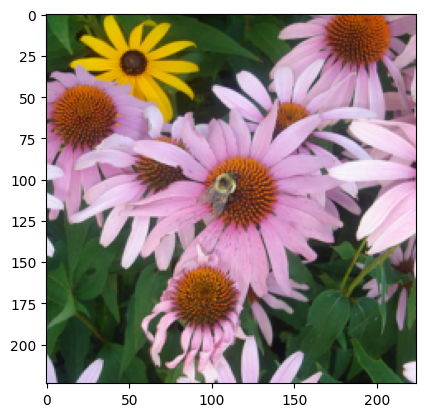

In [33]:
# 전체 데이터 셋 로드
x, y = next(iter(train_dataset))

# 하나의 샘플 이미지를 시각화
dim = x.shape[1]
print("Dimension of iamge:", x.shape, "\n",
      "Dimension of labels:", y.shape)
# 161번쨰 이미지를 선택 후 텐서의 모양을 재구성 한 뒤, 차원이 1인 부분 제거 후 전치한 뒤, 시각화 하기 위해 Numpy 배열로 변환
plt.imshow(x[160].reshape(1, 3, 224, 224).squeeze().T.numpy())

In [35]:
x, y = next(iter(train_dataset))
print(x.shape) # x 텐서의 차원 -> 224개의 행과 150528개의 열
print(len(y[y == 0])) # y == 0인 요소의 개수

torch.Size([244, 150528])
123


In [40]:
# Logistic Regression 구현
class LR(nn.Module):
  def __init__(self, dim, lr=torch.scalar_tensor(0.01)):
    super(LR, self).__init__()
    # 파라미터 초기화
    self.w = torch.zeros(dim, 1, dtype=torch.float).to(device)
    self.b = torch.scalar_tensor(0).to(device)
    self.grads = {
        "dw": torch.zeros(dim, 1, dtype=torch.float).to(device),
        "db": torch.scalar_tensor(0).to(device)
    }
    self.lr = lr.to(device)

  def forward(self, x):
    # forward 연산 정의
    z = torch.mm(self.w.T, x) + self.b
    a = self.sigmoid(z)
    return a

  def sigmoid(self, z):
    return 1 / (1 + torch.exp(-z))

  def backward(self, x, yhat, y):
    # 미분값 계산하는 과정을 정의. PyTorch nn.Module은 backward를 재정의 가능
    self.grads['dw'] = (1/x.shape[1]) * torch.mm(x, (yhat - y).T)
    self.grads['db'] = (1/x.shape[1]) * torch.sum(yhat - y)

  def optimize(self):
    # 최적화 방법 정의
    self.w = self.w - self.lr * self.grads["dw"]
    self.b = self.b - self.lr * self.grads["db"]

# loss function 정의
def loss(yhat, y):
  m = y.size()[1]
  return -(1/m) * torch.sum(y * torch.log(yhat) + (1-y) * torch.log(1-yhat))

  # 예측한 결과인 확률 값을 0과 1로 변환 후, accuracy를 반환하는 함수 정의
def predict(yhat, y):
  y_prediction = torch.zeros(1, y.size()[1])
  for i in range(yhat.size()[1]):
    if yhat[0, i] <= 0.5:
      y_prediction[0, i] = 0
    else:
      y_prediction[0, i] = 1
  return 100 - torch.mean(torch.abs(y_prediction - y)) * 100

In [43]:
# 데이터 로드
x, y = next(iter(train_dataset))

# flatten/transform the data
x_flatten = x.T
y = y.unsqueeze(0)

# flatten된 이미지의 dimension 계산
dim = x_flatten.shape[0]

# model 객체 생성
model = LR(dim)
model.to(device)
yhat = model.forward(x_flatten.to(device))
yhat = yhat.data.cpu()

# loss 계산
cost = loss(yhat, y)
prediction = predict(yhat, y)
print("Cost: ", cost)
print("Accuracy: ", prediction)

# gradient 게산과 함께 Optimize
model.backward(x_flatten.to(device), yhat.to(device), y.to(device))
model.optimize()

Cost:  tensor(0.6931)
Accuracy:  tensor(50.4098)


In [47]:
costs = []
dim = x_flatten.shape[0]
# 하이퍼 파라미터 정의
learning_rate = torch.scalar_tensor(0.0001).to(device)
num_iterations = 100

# model 객체 생성
lrmodel = LR(dim, learning_rate)
lrmodel.to(device)

# test 데이터 변환을 위해 정의한 flatten 함수
def transform_data(x, y):
  x_flatten = x.T
  y = y.unsqueeze(0)

  return x_flatten, y

# 학습 코드
for i in range(num_iterations):
  x, y = next(iter(train_dataset))
  test_x, test_y = next(iter(test_dataset))
  x, y = transform_data(x, y)
  test_x, test_y = transform_data(test_x, test_y)

  # 전체 데이터 셋을 모두 연산하고 로스를 계산
  yhat = lrmodel.forward(x.to(device))
  cost = loss(yhat.data.cpu(), y)
  train_pred = predict(yhat, y)

  # gradient 계산
  lrmodel.backward(x.to(device),
                   yhat.to(device),
                   y.to(device))
  # 최적화
  lrmodel.optimize()

  # test set에 대한 예측 수행
  yhat_test = lrmodel.forward(test_x.to(device))
  test_pred = predict(yhat_test, test_y)

  if i % 10 == 0:
    costs.append(cost)

  if i % 10 == 0:
    print("Cost after iteration {}: {} | Train Acc: {} | Test Acc: {}".format(i,
                                                                              cost,
                                                                              train_pred,
                                                                              test_pred))

Cost after iteration 0: 0.6931472420692444 | Train Acc: 50.40983581542969 | Test Acc: 45.75163269042969
Cost after iteration 10: 0.6691464185714722 | Train Acc: 64.3442611694336 | Test Acc: 54.24836730957031
Cost after iteration 20: 0.6513172388076782 | Train Acc: 68.44261932373047 | Test Acc: 54.24836730957031
Cost after iteration 30: 0.6367813944816589 | Train Acc: 68.03278350830078 | Test Acc: 54.24836730957031
Cost after iteration 40: 0.6245324611663818 | Train Acc: 69.67213439941406 | Test Acc: 54.90196228027344
Cost after iteration 50: 0.6139213442802429 | Train Acc: 70.90164184570312 | Test Acc: 56.20914840698242
Cost after iteration 60: 0.6045222878456116 | Train Acc: 72.54098510742188 | Test Acc: 56.86274337768555
Cost after iteration 70: 0.5960499048233032 | Train Acc: 74.18032836914062 | Test Acc: 57.51633834838867
Cost after iteration 80: 0.58830726146698 | Train Acc: 73.77049255371094 | Test Acc: 57.51633834838867
Cost after iteration 90: 0.5811545848846436 | Train Acc: 74

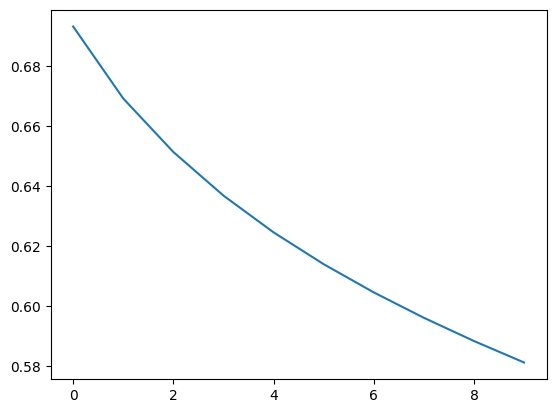

In [48]:
# loss 그래프 시각화
plt.plot(costs)
plt.show()